# Saliency Maps

## Theoretical Explanation

References:
* https://towardsdatascience.com/practical-guide-for-visualizing-cnns-using-saliency-maps-4d1c2e13aeca
* https://www.marktechpost.com/2022/03/07/an-introduction-to-saliency-maps-in-deep-learning/
* https://andrewschrbr.medium.com/saliency-maps-for-deep-learning-part-1-vanilla-gradient-1d0665de3284

Saliency maps get a step further by providing an interpretable technique to investigate hidden layers in CNNs. It is the oldest and most frequently used explanation method for interpreting the predictions of convolutional neural networks. The saliency map is built using gradients of the output over the input. This highlights the areas of the images which were relevant for the classification.

Images are processed using saliency maps to distinguish visual features. Colored photos, for example, are converted to black-and-white pictures so that the strongest colors can be identified. Two other examples are the infrared to detect temperature (red is hot, blue is cold) and the night vision to identify light sources (green is bright and black is dark).

For example, we can see below that water plays a significant role when recognizing a ship. Maybe the model won’t be so successful if it is given a ship outside water in a construction site. This observation provides important clues about the need to retrain the model with additional images of ships in different environmental conditions.

<img src="https://miro.medium.com/max/720/1*3jDaNUm4ilH3XOi9icAKnw.png" width="500">

There is a lot techniques based on saliency maps but in this notebook we focus on the Vanilla Gradient:
1. Forward pass with data
2. Backward pass to input layer to get the gradient
3. Render the gradient as a normalized heatmap

## Tensorflow General configs and imports

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import pandas as pd 
import numpy as np
import seaborn as sns
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Imports

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.cm as cm
import pathlib

# Data pre-processing

In [3]:
# Obtain and prepare dataset

data_dir = pathlib.Path('../input/monkeypoxdataset/MonkeypoxSkinDataset')

# Input size Final
batch_size = 32
IMG_SIZE = (124,124)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle=True,
  image_size=IMG_SIZE,
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle=True,
  image_size=IMG_SIZE,
  batch_size=batch_size)

class_names = train_ds.class_names

Found 42350 files belonging to 6 classes.
Using 33880 files for training.
Found 42350 files belonging to 6 classes.
Using 8470 files for validation.


In [4]:
train_ds = train_ds.cache().prefetch(1)
val_ds = val_ds.cache().prefetch(1)

val_batches = val_ds.cardinality().numpy()
test_ds = val_ds.take(val_batches // 3) 
val_ds = val_ds.skip(val_batches // 3)

normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

## Transfer Learning on Xception model

In [5]:
# create the base pre-trained model
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# and a logistic layer -- let's say we have 6 classes
predictions = Dense(6, activation='softmax')(x)

83697664/83683744 [==============================] - 3s 0us/step


In [6]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [7]:
# this is the model we will train
xception_model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
# Load model if already trained
# Ignore warning "Could not open.." - it will work even with that message

xception_model.load_weights('../input/xceptionmodeltf/xceptionmodeltfv2')

In [9]:
# Even if you load an already trained model in cell above you need to compile it as well

optimizer = tf.keras.optimizers.Adam(epsilon=0.01)

xception_model.compile(
    optimizer=optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [10]:
# Training (will take time if no GPU or TPU is being used - even with GPU/TPU it takes a while)
# Dont run it if you already load the weights

history = xception_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = 10,
)

Epoch 1/10
1059/1059 [==============================] - 92s 78ms/step - loss: 0.3508 - accuracy: 0.8814 - val_loss: 0.4083 - val_accuracy: 0.8536
Epoch 2/10
1059/1059 [==============================] - 36s 34ms/step - loss: 0.3374 - accuracy: 0.8853 - val_loss: 0.3961 - val_accuracy: 0.8566
Epoch 3/10
1059/1059 [==============================] - 37s 35ms/step - loss: 0.3222 - accuracy: 0.8903 - val_loss: 0.3858 - val_accuracy: 0.8590
Epoch 4/10
1059/1059 [==============================] - 37s 35ms/step - loss: 0.3091 - accuracy: 0.8945 - val_loss: 0.3776 - val_accuracy: 0.8624
Epoch 5/10
1059/1059 [==============================] - 36s 34ms/step - loss: 0.2981 - accuracy: 0.8983 - val_loss: 0.3711 - val_accuracy: 0.8636
Epoch 6/10
1059/1059 [==============================] - 36s 34ms/step - loss: 0.2886 - accuracy: 0.9016 - val_loss: 0.3658 - val_accuracy: 0.8677
Epoch 7/10
1059/1059 [==============================] - 36s 34ms/step - loss: 0.2804 - accuracy: 0.9043 - val_loss: 0.3615 -

<AxesSubplot:>

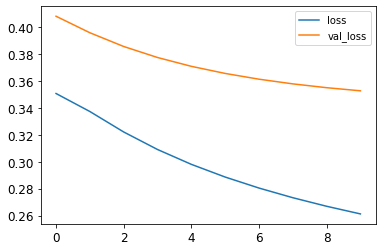

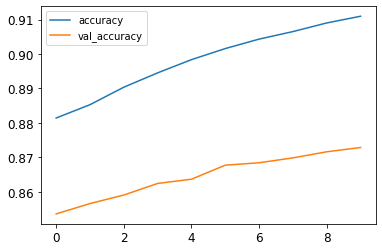

In [11]:
# Results visualization
# Loss and validation loss variation 

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [12]:
#Save the previous trained model

modelSaving = xception_model.save_weights('./xceptionmodel', save_format='h5')

In [13]:
#test sample evaluation

score = xception_model.evaluate(test_ds)
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

88/88 [==============================] - 3s 29ms/step - loss: 0.3263 - accuracy: 0.8835
Test loss:  0.3263017237186432
Test accuracy:  0.8835227489471436


## Saliency Maps implementation

In [14]:
# Help functions

def input_img(path):
    image = tf.image.decode_png(tf.io.read_file(path))
    image = tf.expand_dims(image, axis=0)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224,224])
    return image

def normalize_image(img):
    grads_norm = img[:,:,0]+ img[:,:,1]+ img[:,:,2]
    grads_norm = (grads_norm - tf.reduce_min(grads_norm))/ (tf.reduce_max(grads_norm)- tf.reduce_min(grads_norm))
    return grads_norm

def get_image():
    import urllib.request
    filename = 'image.jpg'
    img_url = r"https://upload.wikimedia.org/wikipedia/commons/d/d7/White_stork_%28Ciconia_ciconia%29_on_nest.jpg"
    urllib.request.urlretrieve(img_url, filename)
    
def plot_maps(img1, img2,vmin=0.3,vmax=0.7, mix_val=2):
    f = plt.figure(figsize=(15,45))
    plt.subplot(1,3,1)
    plt.title("Saliency Map")
    plt.imshow(img1,vmin=vmin, vmax=vmax, cmap="ocean")
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.title("Input Image")
    plt.imshow(img2, cmap = "ocean")
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.title("Overlayed image")
    plt.imshow(img1*mix_val+img2/mix_val, cmap = "ocean" )
    plt.axis("off")

In [15]:
#Take 3 different images

for images, labels in train_ds.take(7):
    for i in range(9):
        imageSelected = images[i].numpy().astype("float32")
        imageLabel = class_names[labels[i]]
        imageSelected2 = images[i - 1].numpy().astype("float32")
        imageLabel2 = class_names[labels[i - 1]]
        imageSelected3 = images[i - 2].numpy().astype("float32")
        imageLabel3 = class_names[labels[i - 2]]

### Image 1: normal vs normalized imaged

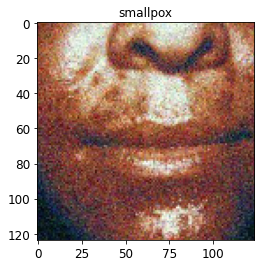

In [16]:
plt.title(imageLabel)
plt.imshow(imageSelected)

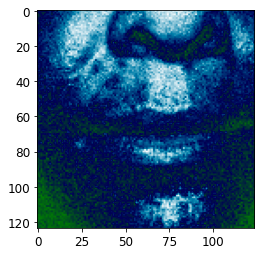

In [17]:
plt.imshow(normalize_image(imageSelected), cmap="ocean")

### Image 2: normal vs normalized imaged

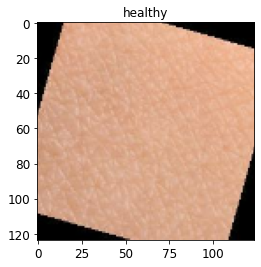

In [18]:
plt.title(imageLabel2)
plt.imshow(imageSelected2)

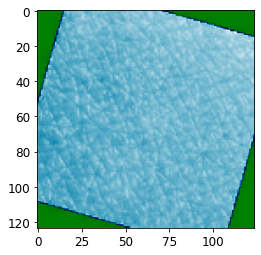

In [19]:
plt.imshow(normalize_image(imageSelected2), cmap="ocean")

### Image 3: normal vs normalized imaged

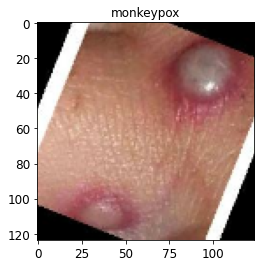

In [20]:
plt.title(imageLabel3)
plt.imshow(imageSelected3)

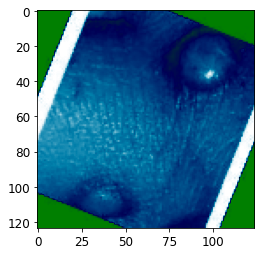

In [21]:
plt.imshow(normalize_image(imageSelected3), cmap="ocean")

### Saliency maps on image 1

In [22]:
preds = xception_model.predict(imageSelected.reshape((1,124,124,3)))
max_idx = preds.argmax(axis=1)
print("Predicted:", class_names[max_idx[0]])

Predicted: smallpox


In [23]:
input_img = tf.convert_to_tensor(imageSelected.reshape((1,124,124,3)), dtype=tf.float32)

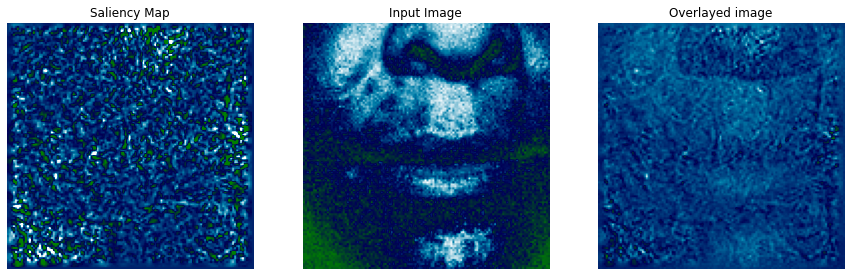

In [24]:
with tf.GradientTape() as tape:
    tape.watch(input_img)
    result = xception_model(input_img)
    max_score = result[0, max_idx[0]]
grads = tape.gradient(max_score, input_img)
plot_maps(normalize_image(grads[0]), normalize_image(input_img[0]))

### Saliency Maps on image 2

In [25]:
preds = xception_model.predict(imageSelected2.reshape((1,124,124,3)))
max_idx = preds.argmax(axis=1)
print("Predicted:", class_names[max_idx[0]])

Predicted: healthy


In [26]:
input_img = tf.convert_to_tensor(imageSelected2.reshape((1,124,124,3)), dtype=tf.float32)

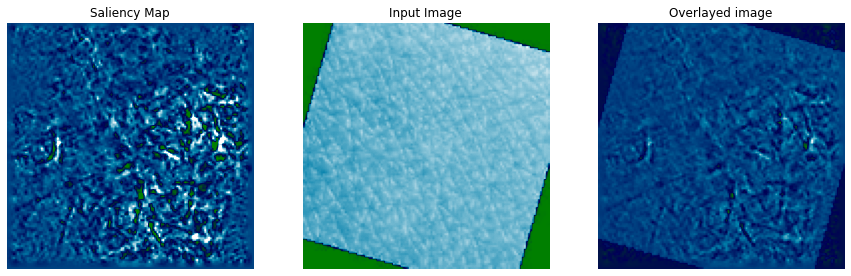

In [27]:
with tf.GradientTape() as tape:
    tape.watch(input_img)
    result = xception_model(input_img)
    max_score = result[0, max_idx[0]]
grads = tape.gradient(max_score, input_img)
plot_maps(normalize_image(grads[0]), normalize_image(input_img[0]))

### Saliency Map on image 3

In [28]:
preds = xception_model.predict(imageSelected3.reshape((1,124,124,3)))
max_idx = preds.argmax(axis=1)
print("Predicted:", class_names[max_idx[0]])

Predicted: chickenpox


In [29]:
input_img = tf.convert_to_tensor(imageSelected3.reshape((1,124,124,3)), dtype=tf.float32)

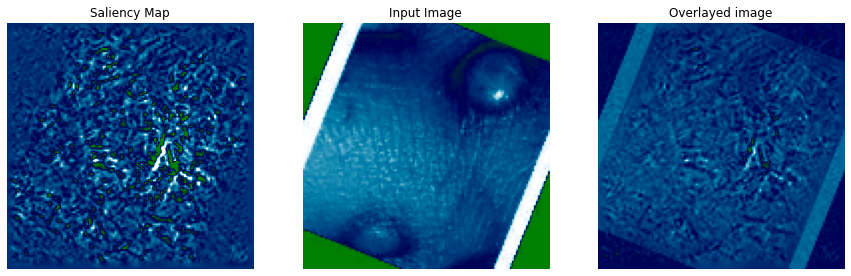

In [30]:
with tf.GradientTape() as tape:
    tape.watch(input_img)
    result = xception_model(input_img)
    max_score = result[0, max_idx[0]]
grads = tape.gradient(max_score, input_img)
plot_maps(normalize_image(grads[0]), normalize_image(input_img[0]))